# Comparing collections

* Set comparison
* Ordered collections
* Ranked collections
* Collection transformation

In [1]:
import random
import collections
import operator

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
%matplotlib inline

import count_min

# some matplotlib color-mapping 
cmap = plt.get_cmap('viridis')
c_space = np.linspace(0,99,100)

# Set comparison

In [2]:
a = set(['josh','fiona','scotty','skippy'])
b = set(['jeff','whitney','fiona'])

In [3]:
a.intersection(b)

{'fiona'}

In [4]:
c = set(range(10))
d = set(range(8,15))

In [5]:
c.intersection(d)

{8, 9}

In [6]:
c.union(d)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

# List comparison

## Number sequences

In [7]:
a = np.array([[i,i+np.random.normal()] for i in range(100)])

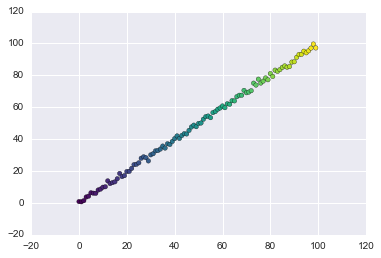

In [8]:
plt.scatter(a[:,0],a[:,1],c=c_space,cmap=cmap)

In [9]:
np.corrcoef(a,rowvar=0)

array([[ 1.        ,  0.99929504],
       [ 0.99929504,  1.        ]])

In [10]:
_ = [1,4,5,8,15,45,48,50,55,60,88,89,90,93,99]
b = np.array([[i,i+np.random.normal()*5] for i in _])

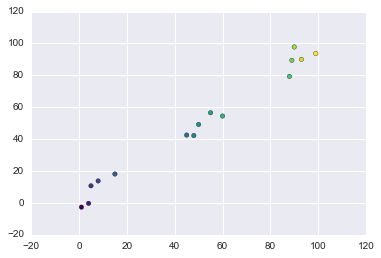

In [11]:
plt.scatter(b[:,0],b[:,1],c=np.linspace(0,99,len(b)),cmap=cmap)

In [12]:
np.corrcoef(b,rowvar=0)

array([[ 1.        ,  0.99096297],
       [ 0.99096297,  1.        ]])

In [13]:
_ = np.array([random.random()*100 for _ in range(100)])
c = np.array([[i,i+np.random.normal()*10] for i in _])

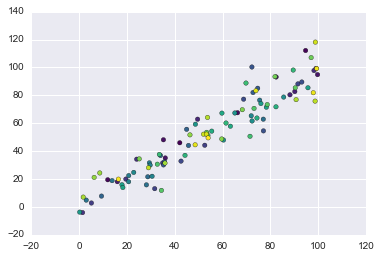

In [14]:
plt.scatter(c[:,0],c[:,1],c=c_space,cmap=cmap)

In [15]:
np.corrcoef(c,rowvar=0)

array([[ 1.        ,  0.94708537],
       [ 0.94708537,  1.        ]])

# Ordinal comparison

e.g. comparing rank

In [158]:
from search.api import Query
import json
import yaml
creds = yaml.load(open('/Users/jkolb/.creds.yaml'))

# set up a query to the Gnip Search API
q = Query(creds['username'],
          creds['password'],
          creds['search_endpoint'],
          paged=True,
          hard_max = 500,
          search_v2 = True
          )

# query parameters
start_date = '2016-08-01T00:00'
end_date = '2016-09-01T00:00'
rule = 'mom'

# get the tweet data
q.execute(rule,start=start_date,end=end_date)
mom_tweets = list(q.get_activity_set())

In [159]:
def token_frequency(tweets,num_top_terms = 30,delta=10**-5,epsilon=0.001,):
    """space-tokenize tweet bodies and 
    return exact and approximate 1-gram counts"""
    
    terms = collections.defaultdict(int)
    sketch = count_min.Sketch(dict(delta=delta,epsilon=epsilon,k=num_top_terms))
    for tweet in tweets:
        for token in tweet['body'].split():
            terms[token.lower()] += 1
            sketch.update(token.lower(),1)
    return (terms,sketch)

In [160]:
def display_two_lists(list_1,list_2):
    for x,y in zip(list_1,list_2):
        print(x,y)
    #x = np.array([list_1,list_2])
    #print(x.transpose())

In [161]:
num_top_terms = 30
delta = 10**-4
epsilon = 0.01

In [163]:
# get exact and approximate top terms and counts
mom_terms,mom_sketch = token_frequency(mom_tweets,num_top_terms,delta,epsilon)
exact_top_mom_terms = list(reversed(sorted(mom_terms.items(),key = operator.itemgetter(1))))[:num_top_terms]
approx_top_mom_terms = [(term,count) for count,term in reversed(sorted(mom_sketch.top_k.values(),key = operator.itemgetter(0)))]

**Kendall's tau coefficient** is a sort of correlation coefficient that is proportional to the difference between the number of _concordant_ pairs and the number of _discordant_ pairs.  

In [164]:
kt_result = scipy.stats.kendalltau(exact_top_mom_terms,approx_top_mom_terms)
kt_result.correlation

/Users/jkolb/pyenvs/3.5.1/lib/python3.5/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


0.84258264678796091

In [165]:
display_two_lists(exact_top_mom_terms,approx_top_mom_terms)

('mom', 388) ('mom', 395)
('my', 273) ('my', 279)
('rt', 243) ('rt', 246)
('i', 183) ('i', 189)
('the', 173) ('the', 178)
('to', 171) ('to', 178)
('and', 126) ('and', 134)
('a', 119) ('a', 125)
('me', 110) ('me', 114)
('is', 99) ('is', 105)
('you', 86) ('you', 96)
('in', 84) ('in', 89)
('for', 73) ('for', 78)
('when', 66) ('when', 72)
('she', 66) ('your', 69)
('your', 62) ('she', 67)
('with', 56) ('with', 66)
('of', 51) ('of', 61)
('get', 47) ('it', 54)
('on', 46) ('be', 52)
('it', 44) ('on', 52)
('be', 42) ('get', 52)
('so', 40) ('so', 50)
('her', 39) ('that', 43)
('that', 36) ('just', 41)
('this', 35) ('her', 41)
('just', 33) ('this', 40)
('if', 33) ('if', 37)
('what', 31) ('have', 37)
('who', 29) ('what', 36)


Next step: how to account for the varying importance of rank?

# Over/under-indexing

In [172]:
# get some data around the term 'dad'

rule = 'dad'
q.execute(rule,start=start_date,end=end_date)
dad_tweets = list(q.get_activity_set())

In [173]:
dad_terms,dad_sketch = token_frequency(dad_tweets,num_top_terms,delta,epsilon)
exact_top_dad_terms = list(reversed(sorted(dad_terms.items(),key = operator.itemgetter(1))))[:num_top_terms]
approx_top_dad_terms = [(term,count) for count,term in reversed(sorted(dad_sketch.top_k.values(),key = operator.itemgetter(0)))]

In [174]:
display_two_lists(exact_top_dad_terms,exact_top_mom_terms)

('dad', 375) ('mom', 388)
('my', 255) ('my', 273)
('rt', 231) ('rt', 243)
('i', 177) ('i', 183)
('to', 158) ('the', 173)
('a', 153) ('to', 171)
('the', 148) ('and', 126)
('and', 138) ('a', 119)
('of', 113) ('me', 110)
('me', 80) ('is', 99)
('in', 79) ('you', 86)
('is', 77) ('in', 84)
('you', 75) ('for', 73)
('his', 74) ('when', 66)
('he', 67) ('she', 66)
('with', 65) ('your', 62)
('trump', 55) ('with', 56)
('that', 50) ('of', 51)
('on', 45) ('get', 47)
('for', 44) ('on', 46)
('this', 43) ('it', 44)
('what', 41) ('be', 42)
('have', 40) ('so', 40)
('be', 39) ('her', 39)
("i'm", 38) ('that', 36)
('dad:', 38) ('this', 35)
('at', 38) ('just', 33)
('like', 37) ('if', 33)
('was', 37) ('what', 31)
('so', 36) ('who', 29)


But we don't really care about rank here. We care about removing the effect of a baseline.

In [178]:
def normalize_by_difference(term_counts,baseline_counts):
    normed_term_counts = {}
    for term,count in term_counts.items():
        try:
            normed_term_counts[term] = count - baseline_counts[term]
        except KeyError:
            normed_term_counts[term] = count
    return normed_term_counts

In [184]:
normalized_results = normalize_by_difference(dad_terms,mom_terms)
list(reversed(sorted(normalized_results.items(), key = operator.itemgetter(1))))[:20]

[('dad', 360),
 ('of', 62),
 ('he', 59),
 ('his', 57),
 ('trump', 55),
 ('dad:', 38),
 ('died', 34),
 ('a', 34),
 ("trump's", 32),
 ('@kurteichenwald:', 32),
 ('dad.', 31),
 ('medical', 22),
 ('last', 21),
 ('wont', 21),
 ("doesn't", 21),
 ('mexic…', 21),
 ('release', 21),
 ('records.', 21),
 ("alzheimer's.", 21),
 ('happened', 20)]

In [188]:
list(reversed(sorted(normalized_results.items(), key = operator.itemgetter(1))))[-20:]

[('time', -15),
 ('if', -16),
 ('who', -17),
 ('it', -18),
 ('gave', -18),
 ('my', -18),
 ('money', -18),
 ("she's", -19),
 ("mom's", -19),
 ('her', -20),
 ('is', -22),
 ('does', -22),
 ('the', -25),
 ('your', -27),
 ('for', -29),
 ('me', -30),
 ('get', -33),
 ('when', -38),
 ('she', -59),
 ('mom', -355)]

In [189]:
def normalize_by_fraction(term_counts,baseline_counts):
    normed_term_counts = {}
    B = sum(baseline_counts.values())
    A = sum(term_counts.values())
    for term,count in term_counts.items():
        try:
            factor = 1 - (baseline_counts[term] / B)
        except KeyError:
            factor = 1
        normed_term_counts[term] = count * factor 
    return normed_term_counts